# Exploring LeafSnap Dataset

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Create a DataFrame

In [54]:
df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')
df.head()
species_counts = df['species'].value_counts()
# print(species_counts.head(10))


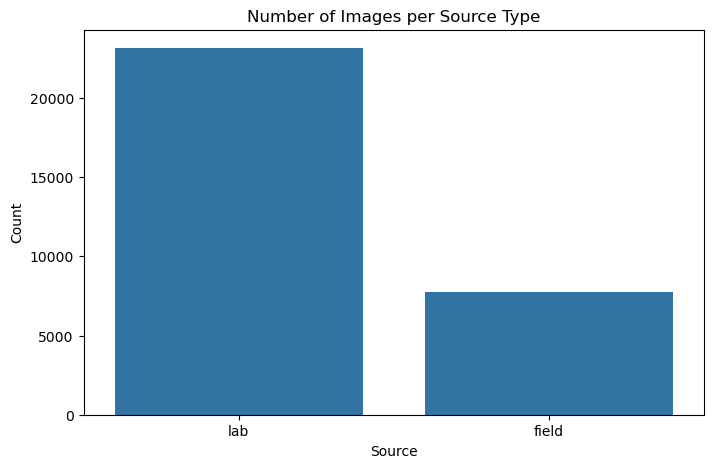

In [55]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='source')
plt.title('Number of Images per Source Type')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

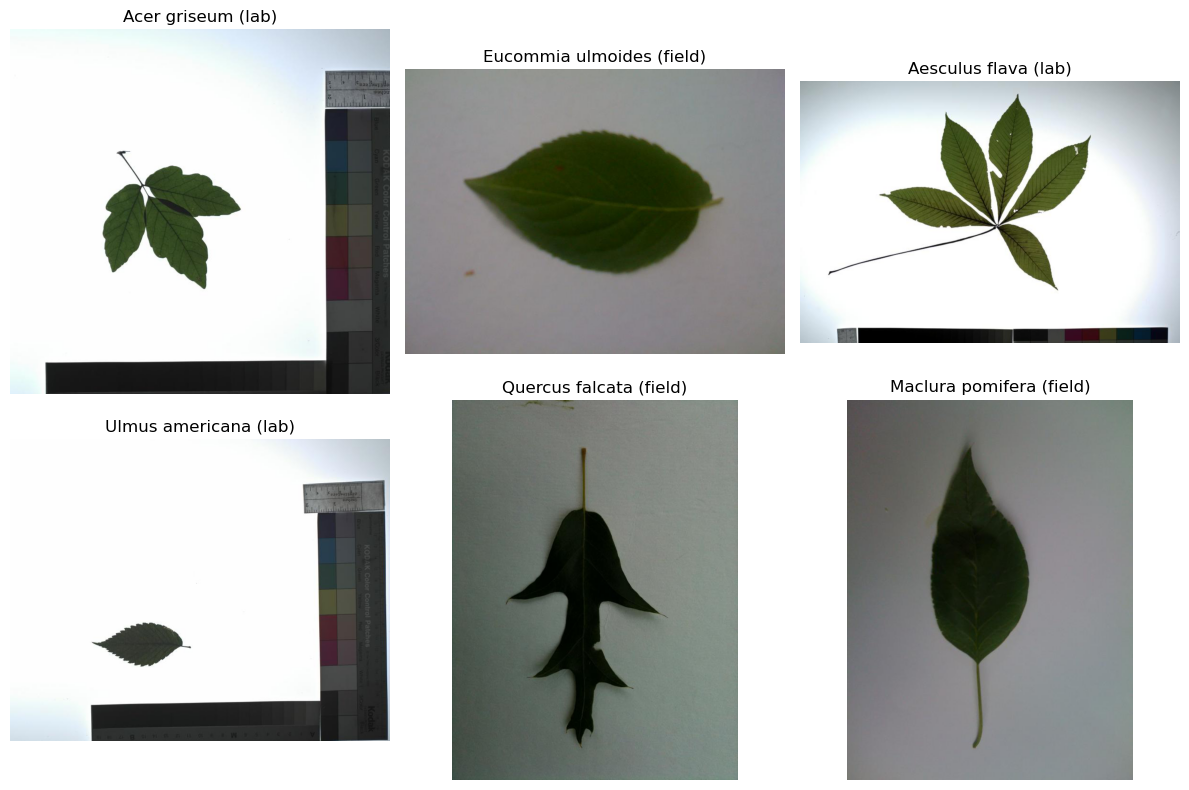

In [56]:

sample = df.sample(6)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row['image_path'])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row['species']} ({row['source']})")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Number of images per species Histogram

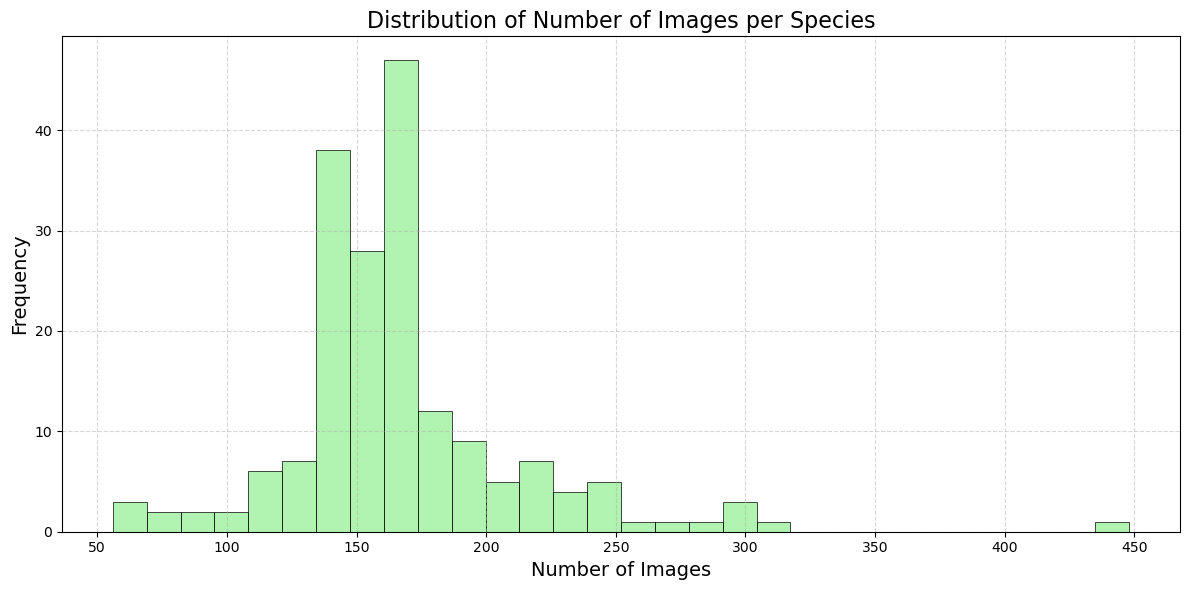

In [57]:
plt.figure(figsize=(12, 6))
sns.histplot(species_counts, bins=30, alpha=0.7, linewidth=0.5, color='lightgreen')
species_counts_df = pd.DataFrame(species_counts).reset_index()
species_counts_df.columns = ['species', 'image_count']
species_counts_df = species_counts_df.sort_values(by='image_count', ascending=False)

plt.title('Distribution of Number of Images per Species', fontsize=16)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Determining what is a "mostly black" image

In [58]:
def black_to_nonblack_ratio(file_path, threshold=15):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (512, 512))
        img_np = img.numpy()

        black_pixels = np.sum(img_np < threshold)
        non_black_pixels = np.sum(img_np >= threshold)

        print(f"black to white ratio: {non_black_pixels / (black_pixels )}")
        if non_black_pixels == 0:
            return float('inf')
        else:
            return black_pixels / non_black_pixels
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    
print("black to nonblack ratio (only scale):")
black_to_nonblack_ratio("dataset/segmented/lab/acer_ginnala/ny1148-03-3.png", 15) 
black_to_nonblack_ratio("dataset/segmented/lab/acer_ginnala/ny1148-10-3.png", 15) 
print("\nblack to nonblack ratio (only leaf):")
black_to_nonblack_ratio("dataset/segmented/lab/acer_ginnala/ny1148-09-1.png", 15)



black to nonblack ratio (only scale):
black to white ratio: 0.034363840827036515
black to white ratio: 0.03406190707233274

black to nonblack ratio (only leaf):
black to white ratio: 0.04867667296060422


20.54372123602893

## Creating a new Dataset
### Using only species with the top 10 most images and have <10% "mostly black" images

In [59]:
def is_mostly_black(file_path, threshold=15, black_ratio=0.95):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (512, 512))
        img_np = img.numpy()
        black_pixels = np.sum(img_np < threshold)
        total_pixels = img_np.size
        ratio = black_pixels / total_pixels
        return ratio >= black_ratio
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

def clean_and_export_dataset(df, output_path='cleaned_dataset.txt'):
    species_black_ratios = {}

    print("Checking images for mostly black pixels...")
    for species in tqdm(df['species'].unique()):
        species_df = df[df['species'] == species]
        black_count = 0

        for path in species_df['segmented_path']:
            if is_mostly_black(path):
                black_count += 1

        total = len(species_df)
        black_ratio = black_count / total
        species_black_ratios[species] = black_ratio

    allowed_species = [species for species, ratio in species_black_ratios.items() if ratio < 0.1]
    df_cleaned = df[df['species'].isin(allowed_species)][['species', 'segmented_path']].reset_index(drop=True)

    df_cleaned.to_csv(output_path, sep='\t', index=False)
    print(f"Saved cleaned dataset with {len(df_cleaned)} images and {len(df_cleaned['species'].unique())} species to '{output_path}'")

    return df_cleaned


df = pd.read_csv("leafsnap-dataset-images.txt", sep='\t')
cleaned_df = clean_and_export_dataset(df)

Checking images for mostly black pixels...


100%|██████████| 185/185 [00:52<00:00,  3.53it/s]

Saved cleaned dataset with 2619 images and 18 species to 'cleaned_dataset.txt'


### Examples of top 3 species

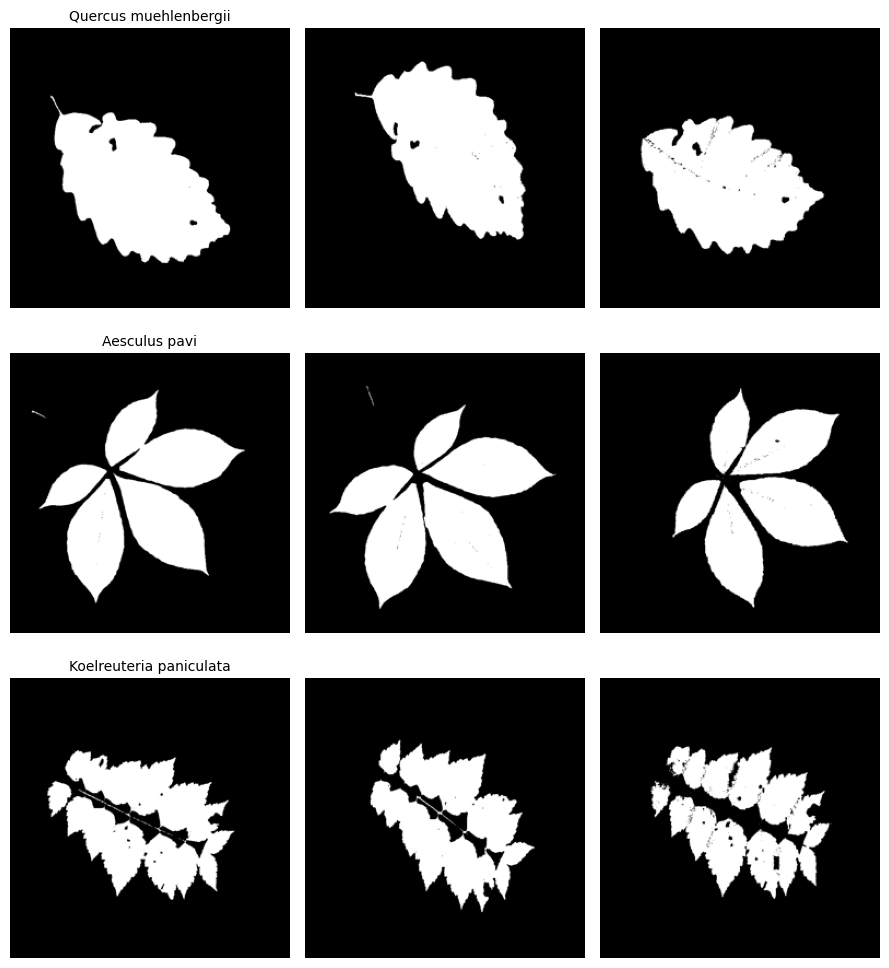

In [60]:
df = pd.read_csv('cleaned_dataset.txt', sep='\t') 


top_species = df['species'].value_counts().nlargest(3).index.tolist()
df_top = df[df['species'].isin(top_species)]

examples = df_top.groupby('species').head(3)
fig, axes = plt.subplots(3, 3, figsize=(9, 10))

for i, species in enumerate(top_species):
    species_examples = examples[examples['species'] == species]
    for j, (_, row) in enumerate(species_examples.iterrows()):
        img_path = row['segmented_path']
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize((256, 256))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(species, fontsize=10)

plt.tight_layout()
plt.show()


## Preprocessing
### Constants

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 20

### Image Resizing

In [90]:
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img / 255.0


### Encode and Split

In [91]:
def encode_and_split(df):
    image_paths = df['segmented_path'].tolist()
    labels = df['species'].tolist()

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    return X_train, X_test, y_train, y_test, label_encoder

### Create Tensorflow Datasets

In [92]:
def create_tf_datasets(X_train, X_test, y_train, y_test):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_ds = test_ds.map(lambda x, y: (preprocess_image(x), y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds

### Fully Prepare Data
- Runs above functions in correct order to preprocess the data

In [93]:
def prepare_leafsnap_data(path='cleaned_dataset.txt'):
    df = pd.read_csv(path, sep='\t') 
    X_train, X_test, y_train, y_test, label_encoder = encode_and_split(df)
    train_ds, test_ds = create_tf_datasets(X_train, X_test, y_train, y_test)
    return train_ds, test_ds, label_encoder

train_ds, test_ds, label_encoder = prepare_leafsnap_data()

### Create CNN

In [94]:

basic_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

basic_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# basic_model.summary()


### Training Montage

In [95]:
start_time = time.time()
history = basic_model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)
end_time = time.time()
seconds = end_time - start_time
minutes = seconds / 60
print(f"Training completed in {seconds:.2f} seconds or {minutes} minutes")
# print accuracy
print(f"Training accuracy: {history.history['accuracy'][-1]} Validation accuracy: {history.history['val_accuracy'][-1]}")

Epoch 1/20


2025-05-01 09:54:32.083443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2095]
	 [[{{node Placeholder/_1}}]]


131/131 [==============================] - ETA: 0s - loss: 1.7815 - accuracy: 0.4401

2025-05-01 09:54:41.077469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [524]
	 [[{{node Placeholder/_1}}]]


131/131 [==============================] - 10s 71ms/step - loss: 1.7815 - accuracy: 0.4401 - val_loss: 1.3837 - val_accuracy: 0.5744
Epoch 2/20
131/131 [==============================] - 9s 71ms/step - loss: 0.7821 - accuracy: 0.7499 - val_loss: 1.2753 - val_accuracy: 0.6489
Epoch 3/20
131/131 [==============================] - 9s 70ms/step - loss: 0.3962 - accuracy: 0.8721 - val_loss: 1.3345 - val_accuracy: 0.6927
Epoch 4/20
131/131 [==============================] - 9s 71ms/step - loss: 0.2437 - accuracy: 0.9255 - val_loss: 1.8512 - val_accuracy: 0.6279
Epoch 5/20
131/131 [==============================] - 9s 71ms/step - loss: 0.1868 - accuracy: 0.9413 - val_loss: 1.6661 - val_accuracy: 0.7195
Epoch 6/20
131/131 [==============================] - 9s 72ms/step - loss: 0.0866 - accuracy: 0.9709 - val_loss: 1.6195 - val_accuracy: 0.7061
Epoch 7/20
131/131 [==============================] - 9s 72ms/step - loss: 0.0767 - accuracy: 0.9766 - val_loss: 1.6401 - val_accuracy: 0.7099
Epoch 8/2

## Evaluation
### Training and Validation Accuracy

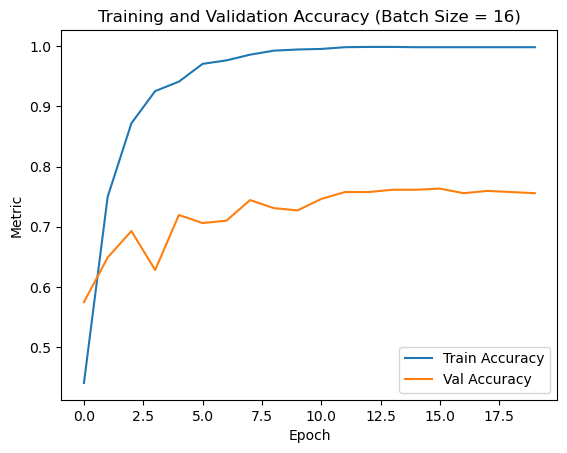

In [96]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training and Validation Accuracy (Batch Size = 16)')
plt.savefig("figures/AccuracyBatch16.png", dpi=300)

### Confusion Matrix

33/33 [==============================] - 1s 22ms/step


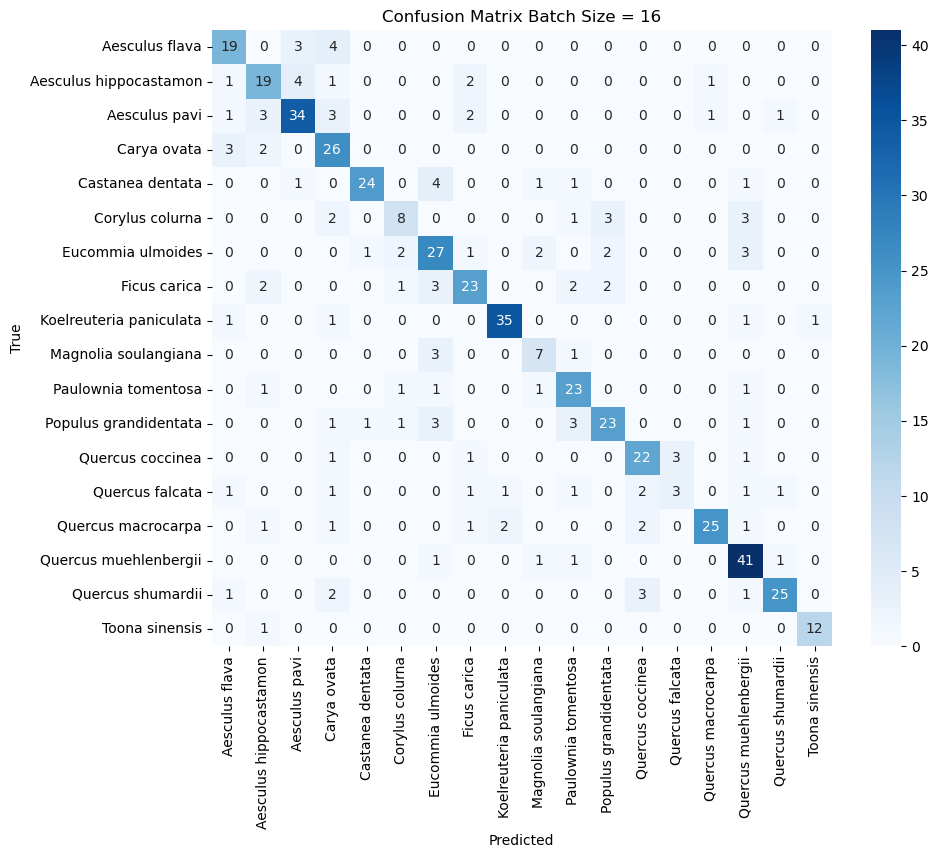

<Figure size 640x480 with 0 Axes>

In [98]:
def plot_confusion_matrix(y_true, y_pred, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Batch Size = 16')
    plt.show()
y_pred = np.argmax(basic_model.predict(test_ds), axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
plot_confusion_matrix(y_true, y_pred, label_encoder)
plt.savefig("figures/ConfusionMatrixBatch16.png", dpi=300)

## Data Cleaning (Again)
### Separate top 10 species with most images (color) taken in the lab

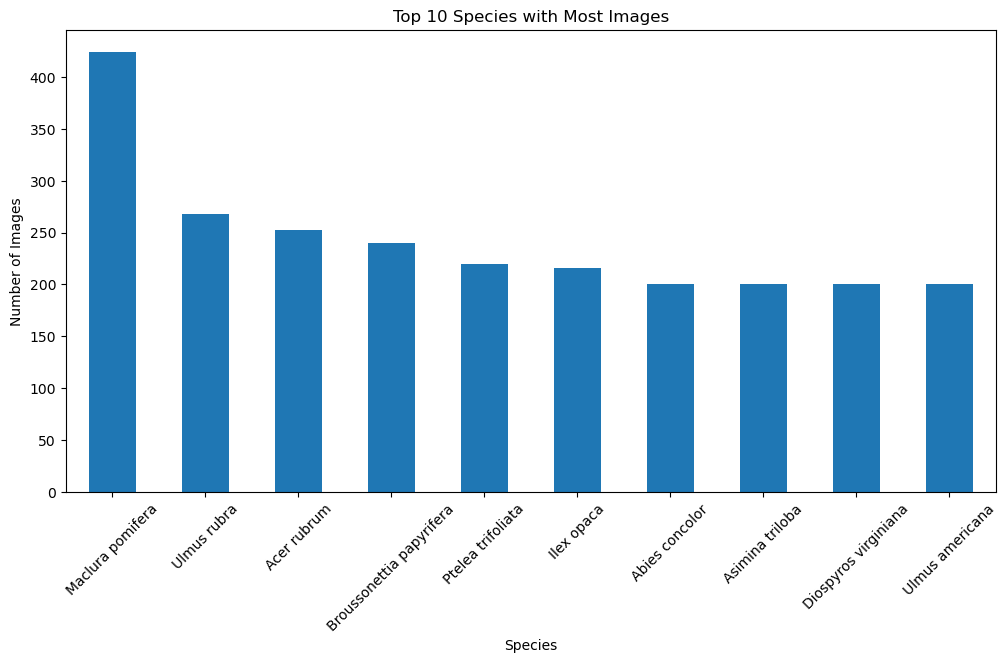

In [ ]:
df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')

top_species = df['species'].value_counts().nlargest(10).index.tolist()
top_species_df = df[df['species'].isin(top_species)]
top_lab_only = top_species[top_species['source'] == 'lab']


top_lab_only.to_csv('leafsnap-top10-lab.txt', sep='\t', index=False)
top_lab_only['species'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Species with Most Images')
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.savefig("figures/Top10Species.png", dpi=300)

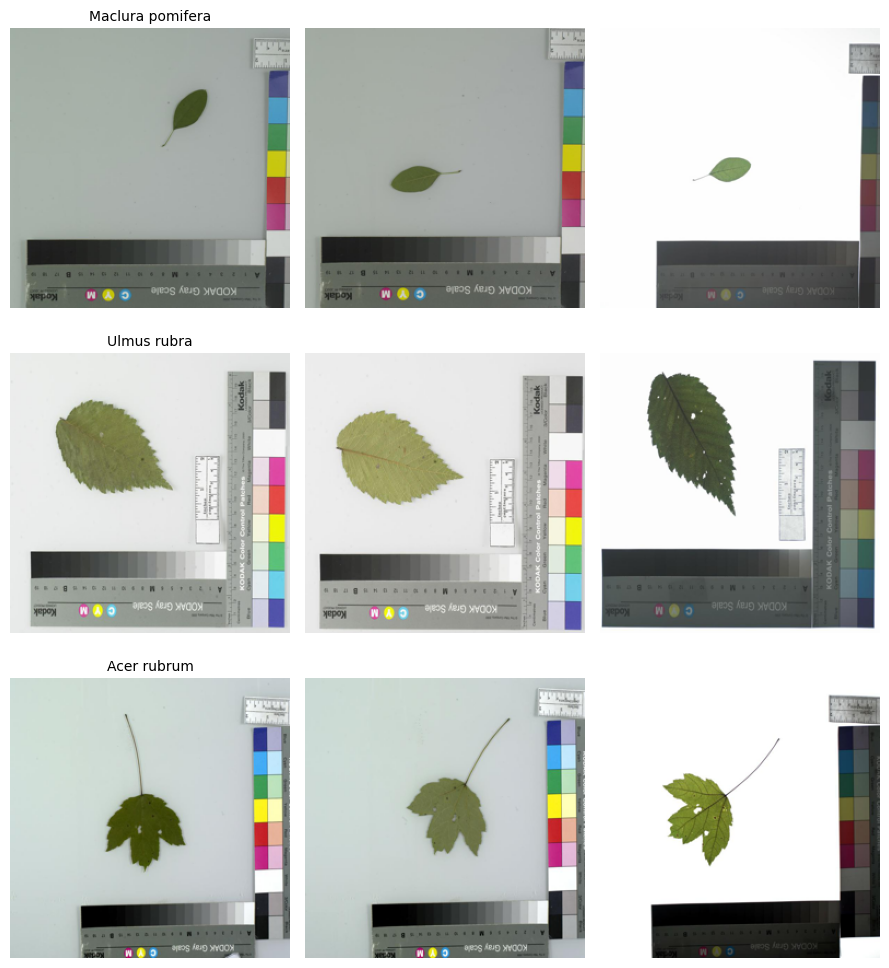

In [19]:
df = pd.read_csv('leafsnap-top10-lab.txt', sep='\t') 


top_species = df['species'].value_counts().nlargest(3).index.tolist()
df_top = df[df['species'].isin(top_species)]

examples = df_top.groupby('species').head(3)
fig, axes = plt.subplots(3, 3, figsize=(9, 10))

for i, species in enumerate(top_species):
    species_examples = examples[examples['species'] == species]
    for j, (_, row) in enumerate(species_examples.iterrows()):
        img_path = row['image_path']
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize((256, 256))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(species, fontsize=10)

plt.tight_layout()
plt.show()


## MobileNetV2 (Transfer Learning)
- Model too complex for BW images (overfitting)


### Data Loading and Hyperparameter Tuning

In [29]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20

df = pd.read_csv("leafsnap-top10-lab.txt", sep="\t")
image_paths = df["image_path"].values
labels = df["species"].astype('category').cat.codes.values
class_names = df["species"].astype('category').cat.categories.tolist()
num_classes = len(class_names)

### Split Data, Load Images, and Augmentation

In [30]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


### Create Model

In [31]:

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

mobileNetV2_model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

mobileNetV2_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


### Training Montage

In [32]:
mobileNetV2_history = mobileNetV2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


2025-05-01 14:10:57.592261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1936]
	 [[{{node Placeholder/_0}}]]
2025-05-01 14:10:57.592456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [1936]
	 [[{{node Placeholder/_1}}]]


61/61 [==============================] - ETA: 0s - loss: 1.4536 - accuracy: 0.5217

2025-05-01 14:12:02.129087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [484]
	 [[{{node Placeholder/_1}}]]
2025-05-01 14:12:02.129488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [484]
	 [[{{node Placeholder/_1}}]]


61/61 [==============================] - 81s 1s/step - loss: 1.4536 - accuracy: 0.5217 - val_loss: 0.6692 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 2/20
61/61 [==============================] - 97s 2s/step - loss: 0.6084 - accuracy: 0.8084 - val_loss: 0.3837 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 3/20
61/61 [==============================] - 100s 2s/step - loss: 0.4068 - accuracy: 0.8781 - val_loss: 0.2967 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 4/20
61/61 [==============================] - 106s 2s/step - loss: 0.3328 - accuracy: 0.8926 - val_loss: 0.2416 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 5/20
61/61 [==============================] - 101s 2s/step - loss: 0.2737 - accuracy: 0.9205 - val_loss: 0.2226 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 6/20
61/61 [==============================] - 107s 2s/step - loss: 0.2189 - accuracy: 0.9385 - val_loss: 0.2283 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 7/20
61/61 [==============================] - 106s 2s/step - loss: 0.2003 - accurac

### Evaluation

Training accuracy:  0.97 Validation accuracy:  0.97


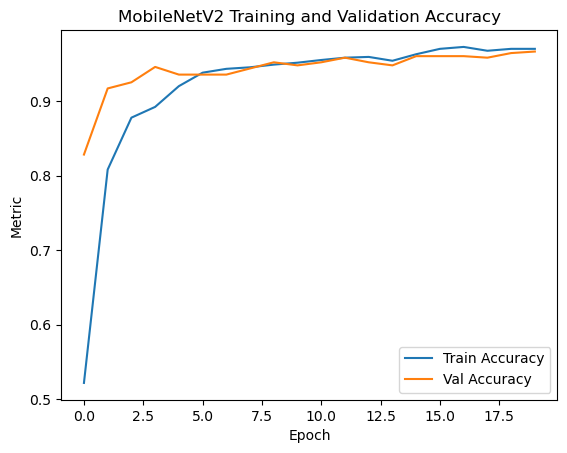

In [33]:
plt.plot(mobileNetV2_history.history['accuracy'], label='Train Accuracy')
plt.plot(mobileNetV2_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('MobileNetV2 Training and Validation Accuracy')
plt.savefig("figures/MobileNetV2Training.png", dpi=300)

print(f"Training accuracy: {mobileNetV2_history.history['accuracy'][-1] : .2f} Validation accuracy: {mobileNetV2_history.history['val_accuracy'][-1]: .2f}")

### Confusion Matrix

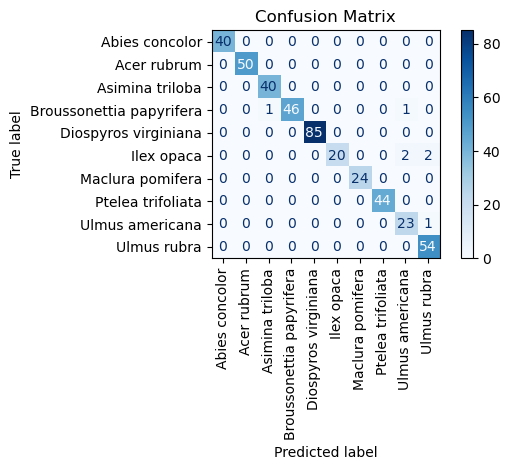

In [34]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("figures/MobileNetV2ConfusionMatrix.png", dpi=300)
plt.show()